# Trajectory Clustering Techniques

## Introduction

This notebook contains different techniques on trajectory clustering discussed in my pattern recognition project course report and can be considered as a demonstration of the report.

The original dataset was civil flight trajectory dataset that is captured on Turkey territory. Since the dataset is large and I do not have right to publish, it was not possible to directly use the project code and observe the result. Also, the project was one of my early studies in data science field so I used some unnecessary things and the was not very clear. For these reason, I decided to apply the same methods mentioned in the paper on a publicly available dataset in a concise tutorial format.

The trajectory is defined as a set of points in n-dimensional space. As a result of this definition, speed and direction features are not considered in clustering process. For example, all of the following trajectories are considered to be the same:

 - `[[0, 0], [1, 1], [2, 2]]`
 - `[[2, 2], [1, 1], [0, 0]]`
 - `[[1, 1], [0, 0], [2, 2]]`

The notebook shows:
 - How to represent trajectory data
 - Haussdorf distance to calculate pairwise distance
 - Applying trajectory segmentation to reduce the number of points for better runtime performance.
 - K-medoid clustering
 - DBSCAN clustering
 - How to plot clustered trajectories

## How to run

Use python 3.6+.

The following libraries are needed to be able to run all code cells without any errors. Please refer to their webpages for installation details.

 - scipy (For fast hausdorff distance implementation)
 - matplotlib and seaborn (For visualizations)
 - scikit-learn (For DBSCAN clustering model)

In [1]:
# 0 - Import related libraries

import urllib
import zipfile
import os
import scipy.io
import math

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN

from kmedoid import kMedoids # kMedoids code is adapted from https://github.com/letiantian/kmedoids

# Some visualization stuff, not so important
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)

In [2]:
# Utility Functions

color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown', 
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])

def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    cluster_count = np.max(cluster_lst) + 1
    
    for traj, cluster in zip(traj_lst, cluster_lst):
        
        if cluster == -1:
            # Means it it a noisy trajectory, paint it black
            plt.plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
        
        else:
            plt.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
    plt.show()

## Dataset

The dataset is obtained from http://cvrr.ucsd.edu/bmorris/datasets/dataset_trajectory_clustering.html.

After downloading, unzipping, importing and preprocessing each trajectory should be a numpy array in `(N, 2)` shape. Each row represents a point in 2 dimensional space. I thingk by little tweaking, code can handle d-dimensional data.

B. T. Morris and M. M. Trivedi, "Learning Trajectory Patterns by Clustering: Experimental
Studies and Comparative Evaluation," in Proc. IEEE Inter. Conf. on Computer Vision and Pattern Recog.,
Maimi, Florida, June. 2009 [pdf](http://cvrr.ucsd.edu/bmorris/docs/morris_cvpr2009.pdf)

In [14]:
# 1 - Get and prepare dataset

dataset_link = 'https://seljuk.me/upload/CVRR_dataset_trajectory_clustering.zip'
data_folder = 'data'
filename = '%s/cross.mat' % data_folder

# Download the dataset
is_download_required = not os.path.exists(data_folder)

if is_download_required:
    zip_filename = 'data.zip'
    urllib.request.urlretrieve(dataset_link, zip_filename)
    zip_ref = zipfile.ZipFile(zip_filename, 'r')
    zip_ref.extractall(data_folder)
    zip_ref.close()

# Import dataset
traj_data = scipy.io.loadmat(filename)['tracks']

traj_lst = []
for data_instance in traj_data:
    traj_lst.append(np.vstack(data_instance[0]).T)

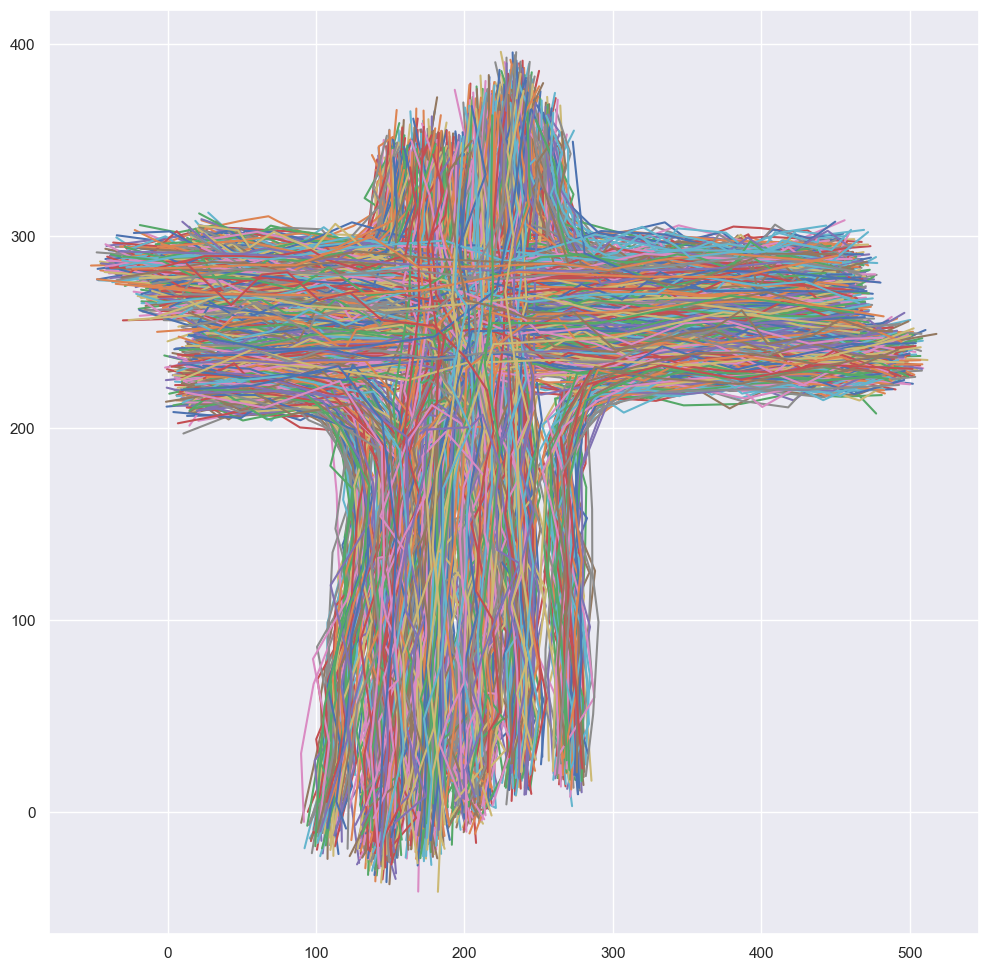

In [13]:
# Plotting

for traj in traj_lst:
    #print(traj)
    plt.plot(traj[:, 0], traj[:, 1])

## Trajectory Segmentation

Calculating distance between trajectories with large number of points can be tricky because of runtime limitations. To overcome this problem, we decided to remove *uninteresting* points from trajectories. To clarify which points are interesting and which are not, we consider a point as a corner point or interesting point if trajectory changes its direction at that point. By storing corner points only, we can reduce the number of points in a trajectory the and therefore we can achieve better runtime performances.

![Trajectory Segmentation](https://raw.githubusercontent.com/Shathra/comparing-trajectory-clustering-methods/master/segmentation.png)

Left shows the original trajectory, right shows the segmented trajectory having smaller set of points.

In [5]:
# 2 - Trajectory segmentation

degree_threshold = 5

for traj_index, traj in enumerate(traj_lst):
    
    hold_index_lst = []
    previous_azimuth= 1000
    
    for point_index, point in enumerate(traj[:-1]):
        next_point = traj[point_index + 1]
        diff_vector = next_point - point
        azimuth = (math.degrees(math.atan2(*diff_vector)) + 360) % 360
        
        if abs(azimuth - previous_azimuth) > degree_threshold:
            hold_index_lst.append(point_index)
            previous_azimuth = azimuth
    hold_index_lst.append(traj.shape[0] - 1) # Last point of trajectory is always added
    
    traj_lst[traj_index] = traj[hold_index_lst, :]

There are many distance functions for trajectories. Here, I use hausdorff distance. For more information: https://en.wikipedia.org/wiki/Hausdorff_distance

Instead of calculating distances, we calculate distance values once and store them in matrix `D`. Since each pair of distances should be calculated and stored, this part of code has O(N^2) time and memory complexity. In the paper, I used sparse matrices to solve the memory issue.

In [6]:
# 3 - Distance matrix

def hausdorff( u, v):
    d = max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])
    return d

traj_count = len(traj_lst)
D = np.zeros((traj_count, traj_count))

# This may take a while
for i in range(traj_count):
    for j in range(i + 1, traj_count):
        distance = hausdorff(traj_lst[i], traj_lst[j])
        D[i, j] = distance
        D[j, i] = distance
    print(i,"of",traj_count)

0 of 1900
1 of 1900
2 of 1900
3 of 1900
4 of 1900
5 of 1900
6 of 1900
7 of 1900
8 of 1900
9 of 1900
10 of 1900
11 of 1900
12 of 1900
13 of 1900
14 of 1900
15 of 1900
16 of 1900
17 of 1900
18 of 1900
19 of 1900
20 of 1900
21 of 1900
22 of 1900
23 of 1900
24 of 1900
25 of 1900
26 of 1900
27 of 1900
28 of 1900
29 of 1900
30 of 1900
31 of 1900
32 of 1900
33 of 1900
34 of 1900
35 of 1900
36 of 1900
37 of 1900
38 of 1900
39 of 1900
40 of 1900
41 of 1900
42 of 1900
43 of 1900
44 of 1900
45 of 1900
46 of 1900
47 of 1900
48 of 1900
49 of 1900
50 of 1900
51 of 1900
52 of 1900
53 of 1900
54 of 1900
55 of 1900
56 of 1900
57 of 1900
58 of 1900
59 of 1900
60 of 1900
61 of 1900
62 of 1900
63 of 1900
64 of 1900
65 of 1900
66 of 1900
67 of 1900
68 of 1900
69 of 1900
70 of 1900
71 of 1900
72 of 1900
73 of 1900
74 of 1900
75 of 1900
76 of 1900
77 of 1900
78 of 1900
79 of 1900
80 of 1900
81 of 1900
82 of 1900
83 of 1900
84 of 1900
85 of 1900
86 of 1900
87 of 1900
88 of 1900
89 of 1900
90 of 1900
91 of 190

692 of 1900
693 of 1900
694 of 1900
695 of 1900
696 of 1900
697 of 1900
698 of 1900
699 of 1900
700 of 1900
701 of 1900
702 of 1900
703 of 1900
704 of 1900
705 of 1900
706 of 1900
707 of 1900
708 of 1900
709 of 1900
710 of 1900
711 of 1900
712 of 1900
713 of 1900
714 of 1900
715 of 1900
716 of 1900
717 of 1900
718 of 1900
719 of 1900
720 of 1900
721 of 1900
722 of 1900
723 of 1900
724 of 1900
725 of 1900
726 of 1900
727 of 1900
728 of 1900
729 of 1900
730 of 1900
731 of 1900
732 of 1900
733 of 1900
734 of 1900
735 of 1900
736 of 1900
737 of 1900
738 of 1900
739 of 1900
740 of 1900
741 of 1900
742 of 1900
743 of 1900
744 of 1900
745 of 1900
746 of 1900
747 of 1900
748 of 1900
749 of 1900
750 of 1900
751 of 1900
752 of 1900
753 of 1900
754 of 1900
755 of 1900
756 of 1900
757 of 1900
758 of 1900
759 of 1900
760 of 1900
761 of 1900
762 of 1900
763 of 1900
764 of 1900
765 of 1900
766 of 1900
767 of 1900
768 of 1900
769 of 1900
770 of 1900
771 of 1900
772 of 1900
773 of 1900
774 of 1900
775 

1347 of 1900
1348 of 1900
1349 of 1900
1350 of 1900
1351 of 1900
1352 of 1900
1353 of 1900
1354 of 1900
1355 of 1900
1356 of 1900
1357 of 1900
1358 of 1900
1359 of 1900
1360 of 1900
1361 of 1900
1362 of 1900
1363 of 1900
1364 of 1900
1365 of 1900
1366 of 1900
1367 of 1900
1368 of 1900
1369 of 1900
1370 of 1900
1371 of 1900
1372 of 1900
1373 of 1900
1374 of 1900
1375 of 1900
1376 of 1900
1377 of 1900
1378 of 1900
1379 of 1900
1380 of 1900
1381 of 1900
1382 of 1900
1383 of 1900
1384 of 1900
1385 of 1900
1386 of 1900
1387 of 1900
1388 of 1900
1389 of 1900
1390 of 1900
1391 of 1900
1392 of 1900
1393 of 1900
1394 of 1900
1395 of 1900
1396 of 1900
1397 of 1900
1398 of 1900
1399 of 1900
1400 of 1900
1401 of 1900
1402 of 1900
1403 of 1900
1404 of 1900
1405 of 1900
1406 of 1900
1407 of 1900
1408 of 1900
1409 of 1900
1410 of 1900
1411 of 1900
1412 of 1900
1413 of 1900
1414 of 1900
1415 of 1900
1416 of 1900
1417 of 1900
1418 of 1900
1419 of 1900
1420 of 1900
1421 of 1900
1422 of 1900
1423 of 1900

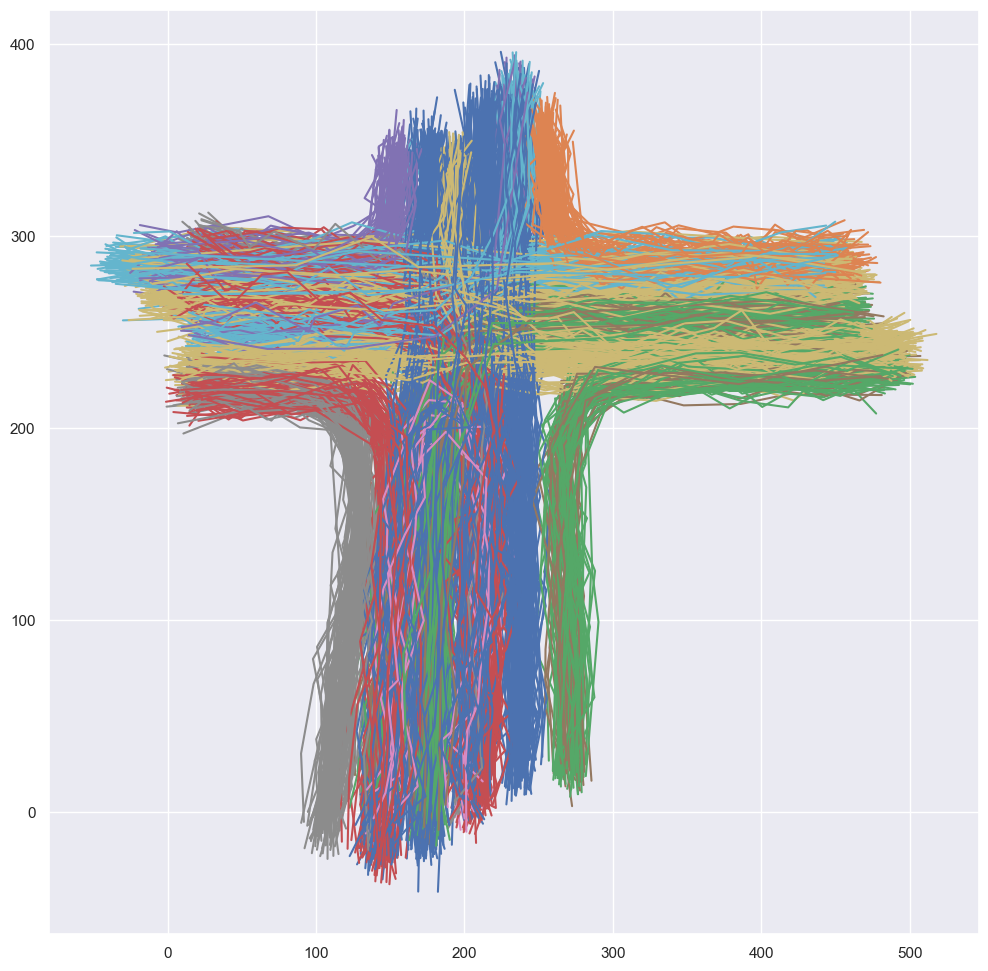

In [7]:
# 4 - Different clustering methods

# 4.1 - kmedoids

k = 10 # The number of clusters
medoid_center_lst, cluster2index_lst = kMedoids(D, k)

cluster_lst = np.empty((traj_count,), dtype=int)

for cluster in cluster2index_lst:
    cluster_lst[cluster2index_lst[cluster]] = cluster
    
plot_cluster(traj_lst, cluster_lst)

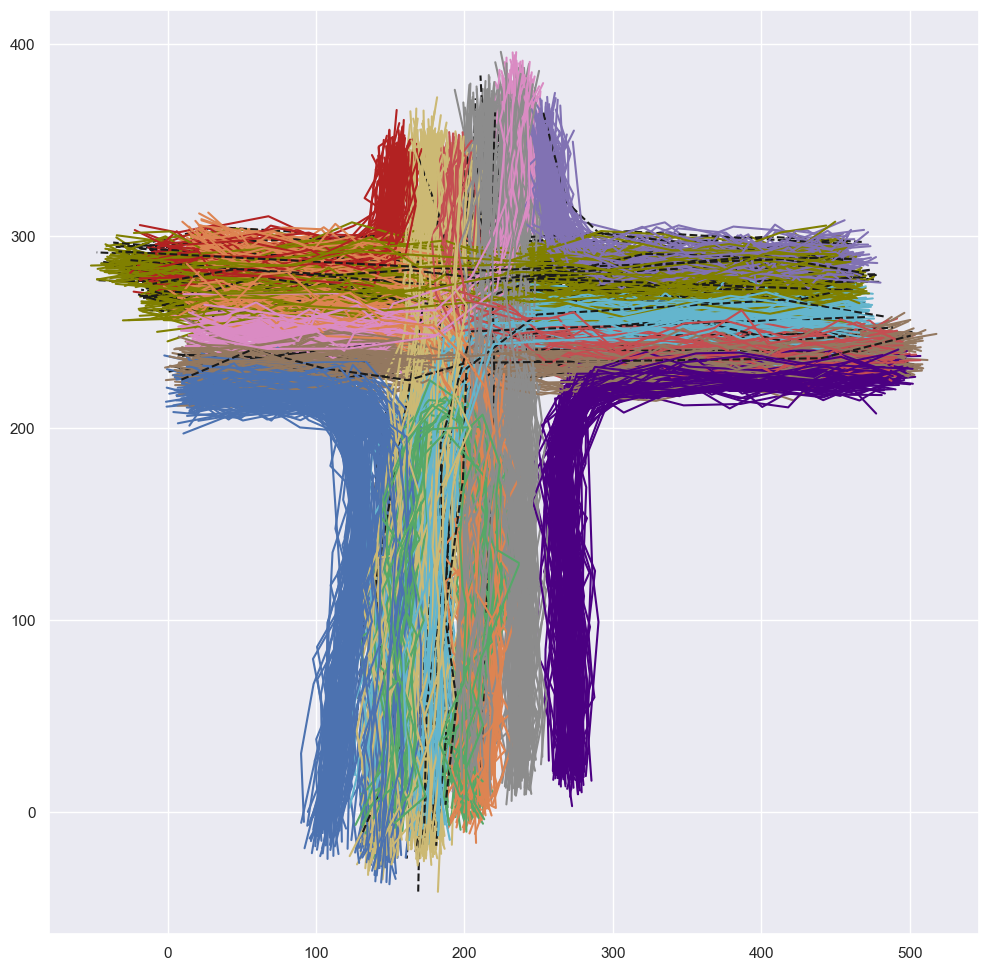

In [8]:
# 4.2 - dbscan

mdl = DBSCAN(eps=400, min_samples=10)
cluster_lst = mdl.fit_predict(D)

plot_cluster(traj_lst, cluster_lst)